In [1]:
"""
To Do List:

- Get color_hist_features 1D vector
- Get bin_spatial_features 1D vector
- Get hog_features 1D vector
- Concatenate the two vectors and normalize (Section 22)
- Train svc.  Pickle the classifier and un-pickle it.
NOTE: Classifier takes 64x64 color images ranging from 0.0-1.0

"""

'\nTo Do List:\n\n- Get color_hist_features 1D vector\n- Get bin_spatial_features 1D vector\n- Get hog_features 1D vector\n- Concatenate the two vectors and normalize (Section 22)\n- Train svc.  Pickle the classifier and un-pickle it.\nNOTE: Classifier takes 64x64 color images ranging from 0.0-1.0\n\n'

In [2]:
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import pickle

In [3]:
# # Normalize from 0-255 (uint-8) to 0-1 (float32)
# def normalize(img):
#     return img.astype(np.float32) / 255 # normalize the data to 0 - 1


# Print out the stats of an image
def print_image_stats(img):
    print("shape           = {}".format(img.shape))
    print("min pixel value = {}".format(np.amin(img)))
    print("max pixel value = {}".format(np.amax(img)))
    print("dtype           = {}".format((img.dtype)))  

    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[np.random.randint(0, len(cars))])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Define a key "min_pixel" and store the minimum pixel value of the test image.
    data_dict["min_pixel"] = np.amin(example_img)
    # Define a key "max_pixel" and store the max pixel value of the test image.
    data_dict["max_pixel"] = np.amax(example_img)
    # Return data_dict
    return data_dict



Load Training Data

In [4]:
# Get lists of all 'car' and 'notcar' images from the dataset
cars = glob.glob('./datasets/vehicles/*/*.png')
notcars = glob.glob('./datasets/non-vehicles/*/*.png')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


Number of cars    = 8792
Number of notcars = 8968
Image shape       = (64, 64, 3)
Data type         = float32
Min pixel value   = 0.047
Max pixel value   = 1.000


Text(0.5,1,'Example Not-car Image')

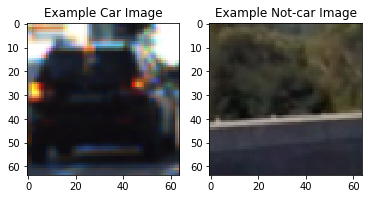

In [5]:
# Get some information about the dataset and show a couple example images
data_info = data_look(cars, notcars)

print("Number of cars    = {}".format(data_info['n_cars']))
print("Number of notcars = {}".format(data_info['n_notcars']))
print("Image shape       = {}".format(data_info['image_shape']))
print("Data type         = {}".format(data_info['data_type']))
print("Min pixel value   = {0:.3f}".format(data_info['min_pixel']))
print("Max pixel value   = {0:.3f}".format(data_info['max_pixel']))

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))# blue car index = 4750
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the example images
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



In [7]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


In [8]:
# # OPTION 1: Train SVC 

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X_train)

# # Apply the scaler to X
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))



102.34 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [9]:
# Train a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Pickle the svc
with open('svc_pickle.p', 'wb') as wf:
    pickle.dump(svc, wf)


19.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9668
My SVC predicts:      [0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
For these 10 labels:  [0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
0.00192 Seconds to predict 10 labels with SVC


In [10]:
# OPTION 2: Restore the SVC from .p file

# Un-pickle the svc
with open('svc_pickle.p', 'rb') as rf:
    svc = pickle.load(rf)

# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


In [11]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

# print(len(rectangles), 'rectangles found in image')

shape           = (720, 1280, 3)
min pixel value = 0
max pixel value = 255
dtype           = uint8


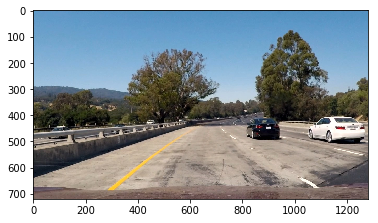

In [12]:
# Create a test frame (...full-size image)
test_frame = mpimg.imread('./test_images/test1.jpg')
img = np.copy(test_img)# REMOVE THIS LINE!!!
print_image_stats(test_frame)
plt.imshow(test_frame)

In [13]:
# def convert_color(img, conv):
#     if conv == 'YUV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#     elif conv == 'HSV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
#     elif conv == 'HLS':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)   
#     elif conv == 'YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     elif conv == 'LUV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#     else:
#         return None   

In [23]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                # convert to (1,n)
                hog_features = np.reshape(hog_features, (1,hog_features.shape[0]))
            else:
                hog_features = hog_feat1
                # convert to (1,n)
                hog_features = np.reshape(hog_features, (1,hog_features.shape[0]))
                

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

...


In [24]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

8 rectangles found in image


In [25]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


...


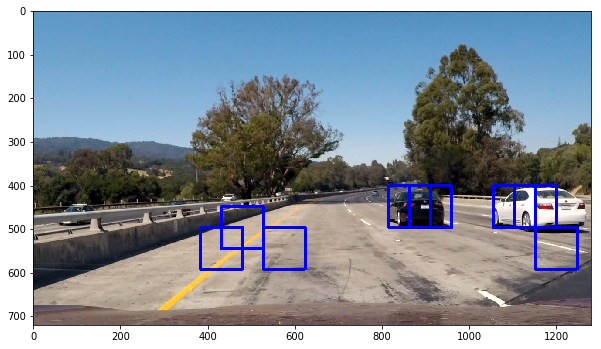

In [26]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

In [ ]:
# # Create a list to store rectangles in once they are found
# rectangles = []

# # Create a copy of the original image (...to draw rectangles on later)
# draw_img = np.copy(img)

# # Rescale pixel values in img from 0-255(uint8) to 0.0-1.0(float32)
# img = img.astype(np.float32)/255

# # Cut sky and car hood out of the image (...no cars will ever be there)
# img_tosearch = img[ystart:ystop,:,:]

# # Change color space
# ctrans_tosearch = convert_color(img_tosearch, 'YUV')

# # Rescale the image
# if scale != 1:
#     imshape = ctrans_tosearch.shape
#     ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

# # Split image into 3 color channels
# ch1 = ctrans_tosearch[:,:,0]
# ch2 = ctrans_tosearch[:,:,1]
# ch3 = ctrans_tosearch[:,:,2]

# # Define number of whole blocks that can fit inside the entire image    
# nxblocks_per_image = ch1.shape[1]//(cell_per_block*pix_per_cell)
# nyblocks_per_image = ch1.shape[0]//(cell_per_block*pix_per_cell)
# nfeat_per_block = orient*cell_per_block**2

# # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
# pix_per_window = 64
# nblocks_per_window = pix_per_window // (pix_per_cell * cell_per_block)
# cells_per_step = 2  # Instead of overlap, define how many cells to step (2 --> .75% overlap)
# nxsteps = ch1.shape[1] // (pix_per_cell * cells_per_step)
# nysteps = ch1.shape[0] // (pix_per_cell * cells_per_step)

# # Compute individual channel HOG features for the entire image
# hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
# hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
# hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

# for xb in range(nxsteps):
#     for yb in range(nysteps):
#         ypos = yb*cells_per_step
#         xpos = xb*cells_per_step
#         # Extract HOG for this patch
#         hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#         hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#         hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#         hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#         reshaped_hog_features = np.reshape(hog_features, (1, hog_features.shape[0]))
        
#         xleft = xpos*pix_per_cell
#         ytop = ypos*pix_per_cell

#         # Extract the image patch
#         subimg = cv2.resize(ctrans_tosearch[ytop:ytop+pix_per_window, xleft:xleft+pix_per_window], (64,64))

# #         # Get color features
# #         spatial_features = bin_spatial(subimg, size=spatial_size)
# #         hist_features = color_hist(subimg, nbins=hist_bins)

#         # Scale features and make a prediction
#         #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#         #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#         test_prediction = svc.predict(reshaped_hog_features)

#         if test_prediction == 1:
#             xbox_left = np.int(xleft*scale)
#             ytop_draw = np.int(ytop*scale)
#             win_draw = np.int(window*scale)
#             cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
